In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [13]:
import keras
from keras.applications import VGG16
from keras.utils import to_categorical
from keras import models
from keras import layers

from keras.models import load_model
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
import tensorflow as tf

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
tf.test.gpu_device_name()

!nvidia-smi

Wed Mar 24 04:53:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'

-rw------- 1 root root 90618980 Mar  4 04:51 '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip

In [11]:
!ls -l

total 20
drwx------ 5 root root 4096 Mar 24 04:54 drive
drwxr-xr-x 1 root root 4096 Mar 18 13:36 sample_data
drwxr-xr-x 4 root root 4096 Mar 24 04:55 test
drwxr-xr-x 4 root root 4096 Mar 24 04:55 train
drwxr-xr-x 4 root root 4096 Mar 24 04:55 validation


In [12]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'

## Import VGG16 Model

In [15]:
conv_base = VGG16(weights = 'imagenet' ,
                  include_top = False,           # DNN 층은 새로 만들겠다
                  input_shape = (150, 150, 3))    # input_shape = (150, 150, 3) 으로 지정해준다

58892288/58889256 [==============================] - 0s 0us/step


In [16]:
conv_base.summary()
# 16개 층 중 dnn을 제외하고 13개 층이 로드

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 1. Feature Extraction

### 1) 특징추출 함수 정의: extract_feature()
- conv_base.predict()

In [18]:
datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 20

def extract_features(directory, sample_count) :
  features = np.zeros(shape = (sample_count, 4, 4, 512))
  labels = np.zeros(shape = (sample_count))

  generator = datagen.flow_from_directory(directory,
                                          target_size = (150, 150),
                                          batch_size = batch_size,
                                          class_mode = 'binary')

  i = 0
  for inputs_batch, labels_batch in generator :
    feature_batch = conv_base.predict(inputs_batch)
    # conv_base를 통과시킴
    # 학습을 하는 것이 아니라, 학습된 파라미터로 연산된 특징맵이 나오게 됨

    features[i * batch_size : (i + 1) * batch_size] = feature_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break

  return features, labels

### 2) 특징추출 함수 적용

In [19]:
%%time

train_features, train_labels = extract_features(train_dir, 2000)
valid_features, valid_labels = extract_features(valid_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 24.4 s, sys: 6.72 s, total: 31.1 s
Wall time: 59.7 s


In [22]:
train_features.shape, valid_features.shape, test_features.shape
# (4, 4, 512) 이므로 4 * 4 * 512, 이것이 강아지인지 고양이인지 확인만 하면 된다
# 매트릭스 연산만 하는 것

((2000, 4, 4, 512), (1000, 4, 4, 512), (1000, 4, 4, 512))

### 3) Reshape Features
- for classification network

In [23]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
valid_features = np.reshape(valid_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [24]:
train_features.shape, valid_features.shape, test_features.shape

((2000, 8192), (1000, 8192), (1000, 8192))

## 2. Keras CNN Modeling with VGG-16 Featured Data

### 1) Model Define
- classification network only
- Dropout Layer

In [25]:
model = models.Sequential()

model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(1, activation = 'sigmoid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


### 2) Model Compile

In [27]:
model.compile(loss = 'binary_crossentropy' ,
              optimizer = 'adam' ,
              metrics = ['accuracy'])

### 3) Model Fit

In [28]:
Hist_dandc = model.fit(train_features, train_labels,
                       epochs = 100,
                       batch_size = 20,
                       validation_data = (valid_features, valid_labels))

Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 0.6009 - accuracy: 0.7508 - val_loss: 0.3431 - val_accuracy: 0.8460
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2651 - accuracy: 0.9025 - val_loss: 0.2804 - val_accuracy: 0.8770
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2008 - accuracy: 0.9220 - val_loss: 0.2685 - val_accuracy: 0.8890
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 0.1716 - accuracy: 0.9292 - val_loss: 0.3129 - val_accuracy: 0.8720
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1494 - accuracy: 0.9424 - val_loss: 0.2523 - val_accuracy: 0.9050
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 0.1131 - accuracy: 0.9582 - val_loss: 0.2608 - val_accuracy: 0.9020
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0795 - accuracy: 0.9667 - val_loss: 0.2938 - val_accuracy: 0.8830

### 4) Visualization

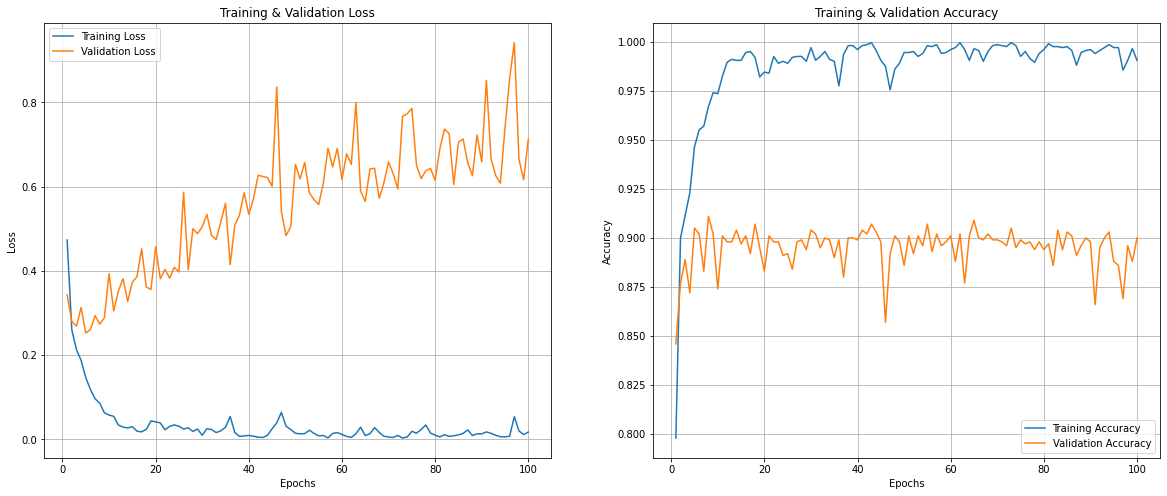

In [30]:
epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss' , 'Validation Loss'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy' , 'Validation Accuracy'])
plt.grid()


plt.show()

### 5) Model Evaluate

In [31]:
loss, accuracy = model.evaluate(test_features, test_labels)

print('Loss: {:.5f}' .format(loss))
print('Accuracy: {:.5f}' .format(accuracy))

32/32 [==============================] - 0s 3ms/step - loss: 0.7804 - accuracy: 0.8770
Loss: 0.78042
Accuracy: 0.87700


## 6. Model Save & Load to Google Drive

In [32]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
model.save('/content/drive/My Drive/Colab Notebooks/models/006_dogs_and_cats_feature_extraction.h5')

In [34]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 144644
-rw------- 1 root root    34592 Mar 18 02:42 001_Model_iris.h5
-rw------- 1 root root 41498896 Mar 23 02:18 002_dogs_and_cats_small.h5
-rw------- 1 root root 41501624 Mar 23 07:12 003_dogs_and_cats_augmentation.h5
-rw------- 1 root root 39879700 Mar 23 06:41 004_logo_classification_with_augmentation.h5
-rw------- 1 root root 25199032 Mar 24 05:22 006_dogs_and_cats_feature_extraction.h5


In [35]:
model_google = load_model('/content/drive/My Drive/Colab Notebooks/models/006_dogs_and_cats_feature_extraction.h5')

In [36]:
loss, accuracy = model_google.evaluate(test_features, test_labels)

print('Loss: {:.5f}' .format(loss))
print('Accuracy: {:.5f}' .format(accuracy))

32/32 [==============================] - 0s 2ms/step - loss: 0.7804 - accuracy: 0.8770
Loss: 0.78042
Accuracy: 0.87700
